In [ ]:
!pip install --quiet lancedb gradio

In [1]:
import lancedb

In [2]:
db = lancedb.connect("~/.lancedb")

## 1. Set up

### Download the data

**OxfordPets Dataset**

https://www.robots.ox.ac.uk/~vgg/data/pets/

Download and unzip [images.tar.gz](https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz)

In [3]:
import pandas as pd
from pathlib import Path
from random import sample

p = Path("~/Downloads/images").expanduser()
uri = []
specie = []
for f in p.iterdir():
    # ignore the bad input
    if f.suffix != ".mat":
        specie.append("cat" if f.name[0].isupper() else "dog")
        uri.append(str(f))
image_df = pd.DataFrame({"uri": uri, "specie": specie})
image_df

,uri,specie
0,/Users/changshe/Downloads/images/Egyptian_Mau_...,cat
1,/Users/changshe/Downloads/images/pug_52.jpg,dog
2,/Users/changshe/Downloads/images/basset_hound_...,dog
3,/Users/changshe/Downloads/images/Siamese_193.jpg,cat
4,/Users/changshe/Downloads/images/shiba_inu_122...,dog
...,...,...
7385,/Users/changshe/Downloads/images/saint_bernard...,dog
7386,/Users/changshe/Downloads/images/pomeranian_83...,dog
7387,/Users/changshe/Downloads/images/scottish_terr...,dog
7388,/Users/changshe/Downloads/images/wheaten_terri...,dog


### Get the embedding function

In [4]:
from lancedb.embeddings import EmbeddingFunctionRegistry

registry = EmbeddingFunctionRegistry.get_instance()
clip = registry.get("open-clip").create(device="mps", batch_size=1024)
clip

OpenClipEmbeddings(name='ViT-B-32', pretrained='laion2b_s34b_b79k', device='mps', batch_size=1024, normalize=True)

### Declare the data model

In [5]:
from lancedb.pydantic import LanceModel, Vector

class Pets(LanceModel):    
    vector: Vector(clip.ndims()) = clip.VectorField()
    specie: str
    uri: str = clip.SourceField()

### Create the table

We just need to feed the images

In [ ]:
table = db.create_table("pets", schema=Pets, mode="overwrite")
table.add(image_df) # this takes a little while since inference is running locally

In [6]:
table = db.open_table("pets")

## 2. Search

Utility function to display the image

In [7]:
import PIL

def show(pet: Pets):
    return PIL.Image.open(pet.uri)    

### By text

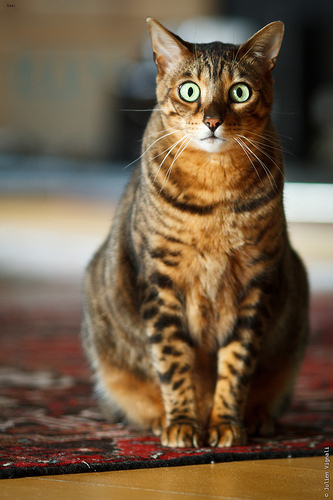

In [8]:
results = table.search("cat").limit(3).to_pydantic(Pets)

show(results[0])

### By image

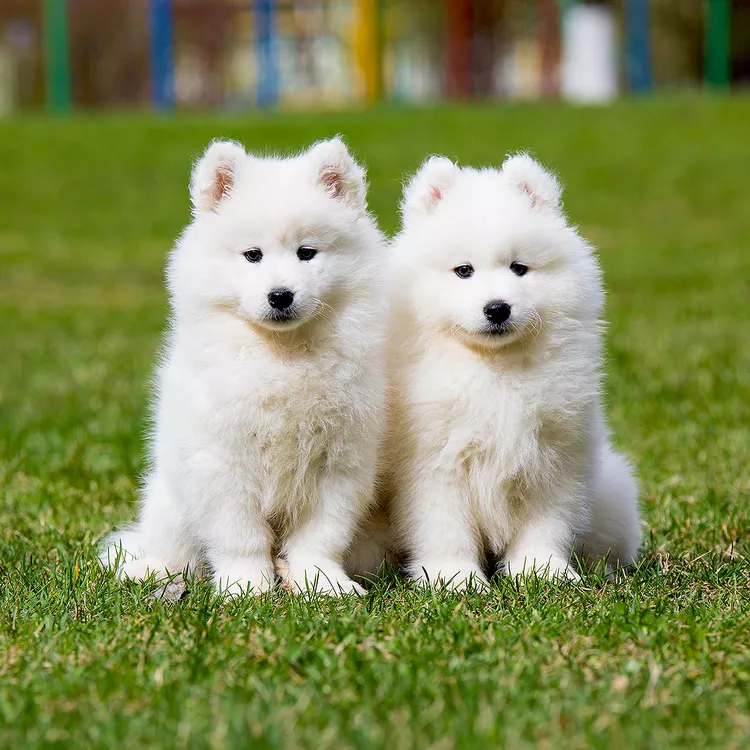

In [9]:
query_image = PIL.Image.open("/Users/changshe/Downloads/baby_samoyeds.webp")
query_image

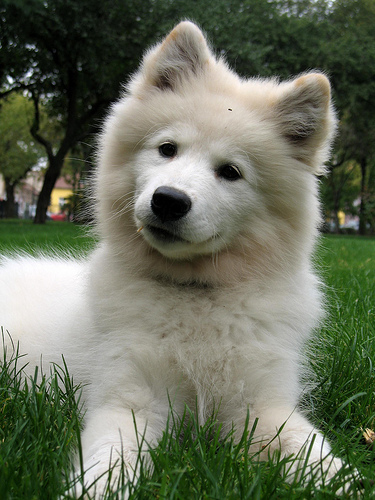

In [10]:
results = table.search(query_image).limit(3).to_pydantic(Pets)

show(results[0])

## 3. Serve

In [12]:
import gradio as gr
import requests

def search_by_image(uri, filter):
    im = PIL.Image.open(requests.get(uri, stream=True).raw)
    query = table.search(im).limit(9)
    if filter:
        query = query.where(f"specie='{filter}'", prefilter=True)
    return [show(p) for p in query.to_pydantic(Pets)]

def search_by_text(query, filter):    
    query = table.search(query).limit(9)
    if filter:
        query = query.where(f"specie='{filter}'", prefilter=True)
    return [show(p) for p in query.to_pydantic(Pets)]

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Tab("Image"):
            image_input = gr.Textbox(value="https://m.media-amazon.com/images/I/819fWMihA7L._AC_SL1500_.jpg", show_label=False)
            b1 = gr.Button("Submit")
        with gr.Tab("Text"):
            text_input = gr.Textbox(value="samoyed", show_label=False)
            b2 = gr.Button("Submit")
    with gr.Row():
        filter = gr.Radio(["cat", "dog"], label="Specie", info="Filter by specie", horizontal=False)        
    with gr.Row():
        gallery = gr.Gallery(
                label="Found images", show_label=False, elem_id="gallery"
            ).style(columns=[3], rows=[3], object_fit="contain", height="auto")   
        
    b1.click(search_by_image, inputs=[image_input, filter], outputs=gallery)
    b2.click(search_by_text, inputs=[text_input, filter], outputs=gallery)

demo.launch()            

/var/folders/nx/jl98zjyj2x1551fzj137b8bh0000gn/T/ipykernel_24283/2711597837.py:26: GradioUnusedKwargWarning: You have unused kwarg parameters in Radio, please remove them: {'horizontal': False}
  filter = gr.Radio(["cat", "dog"], label="Specie", info="Filter by specie", horizontal=False)
/var/folders/nx/jl98zjyj2x1551fzj137b8bh0000gn/T/ipykernel_24283/2711597837.py:30: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  ).style(columns=[3], rows=[3], object_fit="contain", height="auto")


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
